# Character encoding

Loading data from a CSV file is usually a trivial matter of running:

```python
import pandas as pd

pd.read_csv('path/to/file.csv')
```

However it may happen that when trying to run `pd.read_csv` you get a `UnicodeDecodeError` with a long error message who's last line may look something like this:

```
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 7955: invalid start byte
```

## What is an "encoding"?

To understand - and fix - these errors, first let's look at [character encoding](https://en.wikipedia.org/wiki/Character_encoding).

> Character encoding is the process of assigning numbers to graphical characters, especially the written characters of human language, allowing them to be stored, transmitted, and transformed using digital computers.

Ok, but what does that actually look like? Well you might have some raw binary data like:

```
01010100 01101000 01101001 01110011 00100000 01101001 01110011 00100000 01110100 01101000 01100101 00100000 00100111 01100101 00100000 01100001 01100011 01100011 01110101 01110100 01100101 00100000 01100001 01100011 01100011 01100101 01101110 01110100 00100111 00100000 01110011 01111001 01101101 01100010 01101111 01101100 00111010 00100000 11000011 10101001
```

You can use a website like [rapidtables.com](https://www.rapidtables.com/convert/number/ascii-to-binary.html) to convert this to text and get back:

`This is the 'e accute accent' symbol: é`.

However if you convert this with the wrong encoding (i.e. not UTF-8), you might get the wrong characters back, for example:

- Using ASCII encoding: `This is the 'e accute accent' symbol: Ã©`
- Using ISO-2022-JP encoding: `This is the 'e accute accent' symbol: ��`

## Encoding standards
There are many different encoding standards and if you try to *read* a file with the wrong encoding, you end up with garbled text, sometimes referred to as [mojibake](https://en.wikipedia.org/wiki/Mojibake). This is what we saw in the example above (`Ã©` and `��` instead of `é`).

The standard encoding that we should strive to use is [UTF-8](https://www.unicode.org/faq/utf_bom.html#UTF8) (see also the [utf8-chartable page](https://www.utf8-chartable.de/unicode-utf8-table.pl?start=128&number=128&utf8=string-literal&unicodeinhtml=hex) and the [python unicode documentation](https://docs.python.org/3/howto/unicode.html)), however many documents that we come accross use a different standard, such as for example:
- US-ASCII
- INIS-cyrillic
- ISO-10646-J-1 (Japanese)

and **many** others, see [here](https://www.iana.org/assignments/character-sets/character-sets.xhtml) for examples.

## Time to look at some code

In [1]:
# Let's start with a string
string = "This is the 'e accute accent' symbol: é"

print(type(string))
string

<class 'str'>


"This is the 'e accute accent' symbol: é"

We can **encode** - convert from `str` to `bytes` - this string using any encoding we like, for example UTF-8, by using the in-built python method [`str.encode`](https://docs.python.org/3/howto/unicode.html#converting-to-bytes):

In [2]:
encoded_bytes_utf8 = string.encode('UTF-8', errors='replace')
encoded_bytes_utf8

b"This is the 'e accute accent' symbol: \xc3\xa9"

In [3]:
# Notice the 'b' before the string, it indicates this is of type `bytes`:
type(encoded_bytes_utf8)

bytes

When we look at the `encoded` object we just get back some _mojibake_ characters (`\xc3\xa9`) as we're assuming this is ASCII:

In [4]:
encoded_bytes_utf8

b"This is the 'e accute accent' symbol: \xc3\xa9"

If we want to print this correctly, we need to **decode** - convert from `bytes` to `str` - these bytes back to a python string using the correct encoding, like so:

In [5]:
decoded_string = encoded_bytes_utf8.decode('UTF-8')
decoded_string

"This is the 'e accute accent' symbol: é"

In [6]:
type(decoded_string)

str

We now get back the correct `str` and characters.

This works because we know the correct encoding, but if we pass an incorrect one, python will throw an error, and this looks suspiciously similar to the error we might get when reading a CSV!

In [7]:
encoded_bytes_utf8.decode('ASCII')

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 38: ordinal not in range(128)

An error might actually be a good thing, depending on which encoding is used, you might get no error but a flawed output:

In [8]:
encoded_bytes_utf8.decode('windows-1252')

"This is the 'e accute accent' symbol: Ã©"

In [9]:
encoded_bytes_utf8.decode('macroman')

"This is the 'e accute accent' symbol: √©"

## Reading and writing files

Let us make a small `DataFrame` and save it with a non-standard encoding:

In [10]:
import pandas as pd

df = pd.DataFrame({'accents': ['à', 'ä', 'é', 'è', 'ê', 'ï', 'ö', 'ù', 'ü']})
df

,accents
0,à
1,ä
2,é
3,è
4,ê
5,ï
6,ö
7,ù
8,ü


If we look at [this list](https://docs.python.org/2.4/lib/standard-encodings.html) of encodings, we might pick a western encoding, like `windows-1252` for example, we could write the `DataFrame` to disk using this encoding:

In [11]:
actual_encoding = 'windows-1252'
df.to_csv('./test_encoding_df.csv', index=False, encoding=actual_encoding)

Now go and look at the file on disk, with your default text editor for example. This will not work.
We can now try to read this using the default UTF-8, but this throws an error too:

In [12]:
pd.read_csv('test_encoding_df.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 8: invalid continuation byte

## Identifying the file encoding

We need a way to identify the correct encoding in the input file, one such solution is [chardet](https://pypi.org/project/chardet/):

In [13]:
import chardet

We can read the file as `bytes` to inspect it:

In [14]:
with open('./test_encoding_df.csv', 'rb') as rawdata:
    print(rawdata.read(1000))

b'accents\n\xe0\n\xe4\n\xe9\n\xe8\n\xea\n\xef\n\xf6\n\xf9\n\xfc\n'


And then use `chardet` to detect the encoding. We use `chardet.detect` to
> Detect the encoding of the given byte string

And then print the result which is a python `dict` and compare with the actual encoding we used when writing the file:

In [15]:
# Look at the first 1000 bytes (using 'rb' in the context manager)
# to try to guess the encoding
with open('./test_encoding_df.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(1000))

# check what the character encoding might be
print(result)
print(f'actual_encoding: {actual_encoding}')

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}
actual_encoding: windows-1252


### Exercise

We see that these don't match, and that `chardet` records a confidence value of `0.73`.

Your task is to read the file `test_encoding_df.csv` that we just created into a `pd.DataFrame` using both encodings provided:
- the encoding detected by `chardet`, call this `df_guessed`.
- the actual encoding used to write the file, call this `df_actual`.

In [16]:
# your solution here


In [17]:
df_guessed = pd.read_csv('test_encoding_df.csv', encoding=result.get('encoding'))
df_actual  = pd.read_csv('test_encoding_df.csv', encoding=actual_encoding)

In [18]:
df_guessed

,accents
0,à
1,ä
2,é
3,è
4,ê
5,ï
6,ö
7,ù
8,ü


In [19]:
df_actual

,accents
0,à
1,ä
2,é
3,è
4,ê
5,ï
6,ö
7,ù
8,ü


Both of these have read the data correctly, but this might not always be the case. And remember that not getting an Error message is no guarantee of correct reading.

Remember to check the `result['confidence']` value of chardet's guess, as you may need to explore some more. In a bind, you might have to loop through a list of possible encodings such as found on [docs.python.org](https://docs.python.org/2.4/lib/standard-encodings.html) for example.

### Exercise

Given this list of encodings:
```python
encodings = 'cp500 windows-1252 iso-8859-15 macroman'.split()
```

1. Write a loop that will save the `df` we just made using each one of those encodings, use that encoding as part of the file name. Use this code if you've changed the `df`: `df = pd.DataFrame({'accents': ['à', 'ä', 'é', 'è', 'ê', 'ï', 'ö', 'ù', 'ü']})`
2. Now for each of these file, use `chardet` to guess the encoding, print out the information in a way of your choosing.
3. Make a plot showing the confidence value for each file.
4. Open the file(s) with the encoding with the highest confidence value(s).

In [20]:
# 1 Write a loop to save the df with each different encoding


In [21]:
# 2 use chardet to guess each file encoding


In [22]:
# 3 Plot confidence values for each file


In [23]:
# 4 Open the file(s) with the highest confidence value(s)


In [24]:
# 1 Write a loop to save the df with each different encoding
encodings = 'cp500 windows-1252 iso-8859-15 macroman'.split()

df = pd.DataFrame({'accents': ['à', 'ä', 'é', 'è', 'ê', 'ï', 'ö', 'ù', 'ü']})

for encoding in encodings:
    df.to_csv(f'./df_encoding_{encoding}.csv', encoding=encoding)

In [25]:
# 2 use chardet to guess each file encoding
import glob

files = glob.glob('./df_encoding_*.csv')

for file in sorted(files):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(1000))
        print(file)
        print("""Chardet encoding:\t{}
Chardet confidence:\t{:.2f}
{}""".format(result['encoding'], result['confidence'], 40*'='))

./df_encoding_cp500.csv
Chardet encoding:	None
Chardet confidence:	0.00
./df_encoding_iso-8859-15.csv
Chardet encoding:	ISO-8859-1
Chardet confidence:	0.73
./df_encoding_macroman.csv
Chardet encoding:	Windows-1254
Chardet confidence:	0.23
./df_encoding_windows-1252.csv
Chardet encoding:	ISO-8859-1
Chardet confidence:	0.73


In [26]:
# 3 Plot confidence values for each file
chardet_encoding, chardet_conf = [], []

for encoding, file in zip(sorted(encodings), sorted(files)):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(1000))
        chardet_encoding.append(result['encoding'])
        chardet_conf.append(result['confidence'])

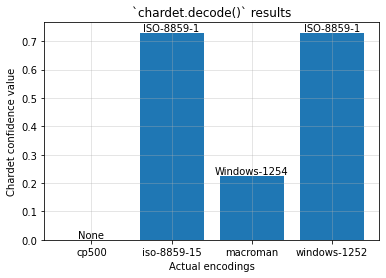

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
p1 = ax.bar(sorted(encodings), chardet_conf)
ax.set_title('`chardet.decode()` results')
ax.set_xlabel('Actual encodings')
ax.set_ylabel('Chardet confidence value')
ax.bar_label(p1, [str(x) for x in chardet_encoding])
ax.grid(alpha=0.4)

In [28]:
# 4 Open the file(s) with the highest confidence value(s)
pd.read_csv('./df_encoding_iso-8859-15.csv', encoding='iso-8859-1')

,Unnamed: 0,accents
0,0,à
1,1,ä
2,2,é
3,3,è
4,4,ê
5,5,ï
6,6,ö
7,7,ù
8,8,ü


In [29]:
pd.read_csv('./df_encoding_windows-1252.csv', encoding='iso-8859-1')

,Unnamed: 0,accents
0,0,à
1,1,ä
2,2,é
3,3,è
4,4,ê
5,5,ï
6,6,ö
7,7,ù
8,8,ü
